### 2D Multiple 2D, 3D, Interactive (includes processing)

###   

###   

filename: RecBCD_plain2.csv    |  pixel_size: 154  |  time_step: 20
frame_start: 0  |    frame_end: -1  |  bin_size: 3
processing: none  |  plot_type: angular_continuous  |  title: Angular Motion (r> 0.167 correction)
X_axis_label: Time (ms)  |  Y_axis_label: Theta (degrees)  |  Z_axis_label: Time (ms)


D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



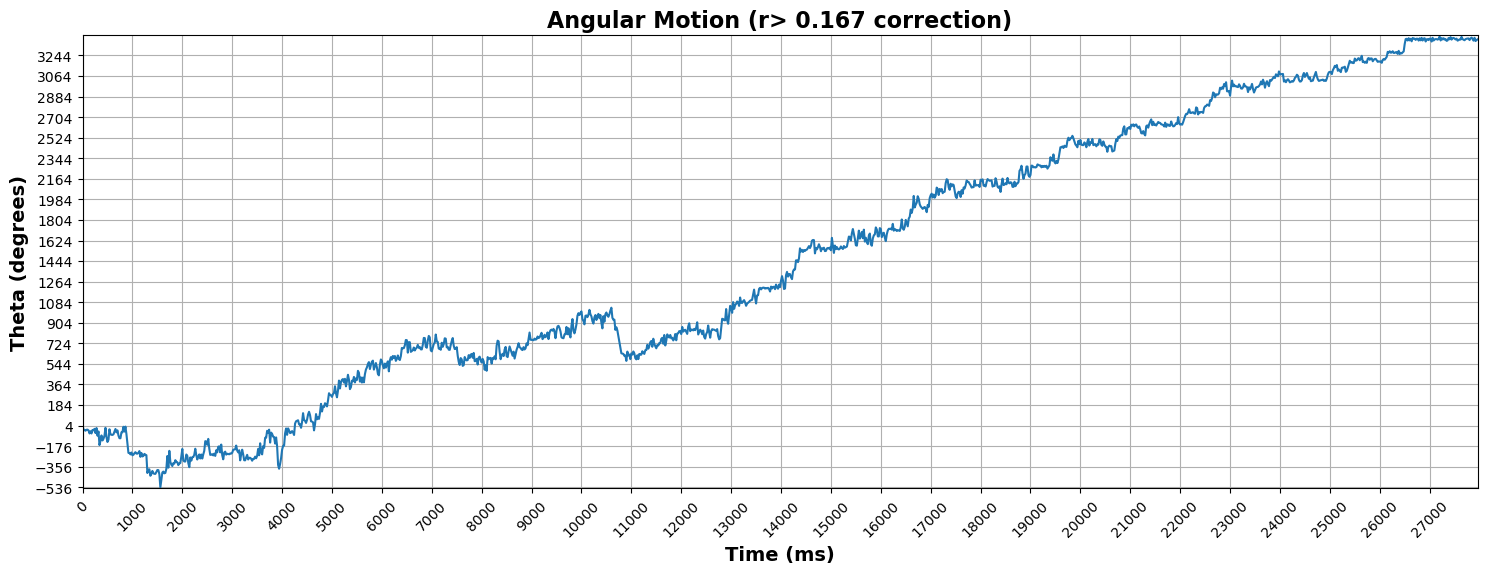

In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Line3DCollection 
from matplotlib import ticker
import math
from matplotlib import gridspec

parameters = {
'file_name': "RecBCD_plain2.csv",
'pixel_size': 154, # in nanometers
'time_step': 20, # in miliseconds
'frame_start': 0, # enter 0 to start from beginning of dataset
'frame_end': -1, # enter -1 to end at the last value of the data set
'bin_size': 3, # bin size for downsample/filter processing
'processing': "none", # enter downsample, filter, or none
'plot_type': "angular_continuous", # enter 2D, 3D, angular, angular_continuous, or interactive
'title': "Angular Motion (r> 0.167 correction)",
'x_axis_label': "Time (ms)",
'y_axis_label': "Theta (degrees)",
'z_axis_label': "Time (ms)",
'unit': "nm",  # enter pixel or nm 
'multi_plot': 'no', # enter yes or no
'frames_per_plot': 25,
'columns': 7, # columns of plots 
'pixel_min': -0.75,
'pixel_max': 0.75,
'axis_increment_pixel': 7, #change axis increments for nicely fitting tick marks (pixel)
'nm_min': -150,
'nm_max': 150,
'axis_increment_nm': 7, #change axis increments for nicely fitting tick marks (nm)
'fig_size_x': 40, #adjust display parameters for graphs to fit nicely, mostly used for multi_plot 
'fig_size_y': 40}    

def display_trajectory_v3(file_name,pixel_size,time_step,frame_start,frame_end,bin_size,processing,plot_type,title,x_axis_label,y_axis_label,z_axis_label,unit, frames_per_plot, columns, pixel_min, pixel_max, nm_min, nm_max,axis_increment_pixel,axis_increment_nm, fig_size_x, fig_size_y, multi_plot):
       
              
        print(*['filename:', file_name, '   | ' , 'pixel_size:', pixel_size , ' | ' , 'time_step:', time_step])
        
        print(*['frame_start:', frame_start,' |   ','frame_end:', frame_end, ' | ', 'bin_size:', bin_size])
        
        print(*['processing:', processing, ' | ',  'plot_type:', plot_type,' | ' ,'title:', title])
        
        print(*['X_axis_label:',x_axis_label,' | ',  'Y_axis_label:',y_axis_label ,' | ' ,'Z_axis_label:', z_axis_label])
        if multi_plot == 'yes' and plot_type == '2D':
            print(*['multi_plot:',multi_plot, '|', 'frames_per_plot:', frames_per_plot])
        
    
        #read data file into a pandas data frame, add an index counter, and label columns
        data = pd.read_csv(file_name, header = None)
        data['index'] = range(len(data))
        data.columns = [ 'X position', 'Y position','index']
        data=data[['index','X position','Y position']]

        # find the average of X and Y column respectively
        ave = data.mean(axis=0)
        xave = ave.loc['X position']
        yave = ave.loc['Y position']

        #substract averages from each column to find displacement, store into new columns
        data["X displacement (pixels)"] = data['X position'] - xave
        data["Y displacement (pixels)"] = data['Y position'] - yave
        # mutiply pixel displacement columns by scaler to find nm displacement, store in new columns
        data["X displacement (nm)"] = data['X displacement (pixels)']*pixel_size
        data["Y displacement (nm)"]= data['Y displacement (pixels)']*pixel_size
        # multiply the index counter column by time_step to make a time step column, store into new column 
        data["Time (ms)"] = data['index']*time_step
        # drop all NaN values *not a number
        data = data.dropna() 
        
        #drop NAN try to conserve time (what if we have NAN in x and not in Y? need to drop the whole row)
        
       
        ## PROCESSING BLOCK

            
        ##Simple Moving Average or "filter" dataframe:
        ma = pd.DataFrame(data.iloc[:,0],columns=['index'])

        window = bin_size
        #Built in simple moving average function is applied to normal data and stored in dataframe "ma"
        ma['X movement' ] = data.iloc[:,1].rolling(window=window).mean()
        ma['Y movement'] = data.iloc[:,2].rolling(window=window).mean()
        ma['X displacement (pixels)'] = data.iloc[:,3].rolling(window=window).mean()
        ma['Y displacement (pixels)'] = data.iloc[:,4].rolling(window=window).mean()
        ma['X displacement (nm)'] = data.iloc[:,5].rolling(window=window).mean()
        ma['Y displacement (nm)'] = data.iloc[:,6].rolling(window=window).mean()
        ma['Time (ms)'] = data.iloc[:,7].rolling(window=window).mean()

        #This block delets the null spaces in the new dataframe and realigns the data
        ma = ma.apply (pd.to_numeric, errors='coerce')
        ma = ma.dropna()
        ma = ma.reset_index(drop=True)
       
        
        
        
        
        
        ##Downsampling dataframe:
        da=pd.DataFrame(data.iloc[:,:])
        #divide original index by sample size and round to nearest whole number to 
        #achieve new index number underwhich the origial index is stored
        u= math.floor(frame_start/bin_size)
        v= math.floor(frame_end/bin_size)

        #isolate the column (if we print this it will show as a dataframe with 2 cols: indexes and time values)
        daT_column=da.iloc[:,7]
        daDY_column=da.iloc[:,6]
        daDX_column=da.iloc[:,5]
        daPY_column=da.iloc[:,4]
        daPX_column=da.iloc[:,3]
        daI_column=da.iloc[:,0]
        daX_column=da.iloc[:,1]
        daY_column=da.iloc[:,2]
        #We just want the values in the column
        daT = daT_column.values
        daDY = daDY_column.values
        daDX = daDX_column.values
        daPY = daPY_column.values
        daPX = daPX_column.values
        daI = daI_column.values
        daX = daX_column.values
        daY= daY_column.values
        #This function taken from https://stackoverflow.com/questions/10847660/subsampling-averaging-over-a-numpy-array
        # allows us to downsample by averages over a set number 
        #(change 'n' to the number of values you want to average over)
        def average(arr, n):
            end =  n * int(len(arr)/n)
            return np.mean(arr[:end].reshape(-1, n), 1)
        #Takes a column from our 'da' dataframe and runs the function over it
        #stores the new values in variables as an array (values in a row)

        #assigning each new row to a varialble
        Time = average(daT,bin_size)
        Index = average(daI,bin_size)
        Xda = average(daX,bin_size)
        Yda = average(daY,bin_size)
        Ydisnm = average(daDY,bin_size)
        Xdisnm = average(daDX,bin_size)
        YdisP = average(daPY,bin_size)
        XdisP = average(daPX,bin_size)

        #reshaping the data in a 1D column
        TimeT = Time[:, np.newaxis]
        YdisnmT = Ydisnm[:, np.newaxis]
        XdisnmT = Xdisnm[:, np.newaxis]
        YdisPT = YdisP[:, np.newaxis]
        XdisPT = XdisP[:,np.newaxis]
        XdaT = Xda[:, np.newaxis]
        YdaT = Yda[:,np.newaxis]
        IndexT = Index[:,np.newaxis]

        #stores in a new dataframe 'dsak' for: downsampling average k, k=bin size
        dsa= pd.DataFrame(IndexT, columns=['index'])
        #appending to our data frame
        dsa['X movement'] = XdaT
        dsa['Y movement'] = YdaT
        dsa['X displacement (pixels)'] = XdisPT
        dsa['Y displacement (pixels)'] = YdisPT
        dsa['X displacement (nm)'] = XdisnmT 
        dsa['Y displacement (nm)'] = YdisnmT
        dsa['Time (ms)'] = TimeT
        
        ## FOR MULTIPLE PLOTS
        # Function for 2D plot parameters (called when user asks for multiple plots)
        def do_plot(ax):
            #regular graphing parameters for 2D graph (color of scatter, size, shape, tick marks, etc.)
            colors = cm.plasma(np.linspace(0, 1, len(z)))
            p=ax.scatter(x, y, c=colors)
            #fig = plt.figure(figsize=(6,6), dpi=100)
            tix = np.linspace(0,len(z),6)
            #tix_c = tix*time_step
            #cbar2.set_ticklabels(tix_c)
            plt.axis('square')
            plt.xticks(rotation=45)
            if unit == "pixel":
                ax.set_xlim(pixel_min, pixel_max) 
                ax.set_ylim(pixel_min, pixel_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                ax.grid()
            if unit == "nm":
                ax.set_xlim(nm_min, nm_max) 
                ax.set_ylim(-150, 150)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.grid()

        
        #future processing methods to be added below:
        
        
        
        
        
        #DETERMINE PROCESSING AND UNIT TYPE:
        #if more processing methods are to be added, an if statement must be
        #added with a key word to select that data frame
        if processing == "none":
            df = data
        if processing == "filter":
            df = ma
        if processing == "downsample":
            df = dsa
            frame_start = math.floor(frame_start/bin_size)
            frame_end = math.floor(frame_end/bin_size)
        
        
        #ADD A COLUMN TO DF FOR THETA (0,360] AND MAKE A NEW DATAFRAME FOR CONTINOUS DEGREE ROTATION
        # radian to degree conversion
        r2d = 180/np.pi
        #arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
      
        df_filter =pd.DataFrame(df.iloc[:,0])
        #find radius
        df_filter['radius'] = np.power( np.power(df['Y displacement (pixels)'],2) + np.power(df['X displacement (pixels)'],2), 0.5 )
        #find theta arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
        df_filter['theta'] = -np.arctan2(df['Y displacement (pixels)'],df['X displacement (pixels)'])*r2d 
        df_filter['Time (ms)'] = df['Time (ms)']
        # if r is greater than a certain value, the entire row of this dataframe is stored into the next dataframe
        df_theta = df_filter[df_filter['radius'] > 0.167] # we conserve the other columns where the row meets the requirement
        
        #arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
        #add 360 onto the 3rd and 4th quadrant values to make range from (0,360)
        df_theta.loc[df_theta['theta'] < 0, ['theta']] += 360
         
        
        #make dataframe for angular continuous (base dataframe changes with user preferences)
        angularc = pd.DataFrame(df_theta.iloc[:,2]) # df_theta.iloc[:,2] is the (0,360) theta range
        angularc.columns = ['theta']
        
        #add a row of zeros at the top and reset index
        zero_row = pd.DataFrame({'theta': 0}, index=[0])
        angularc = pd.concat([zero_row, angularc]).reset_index(drop = True)
        
        # find displacement between rows (row[i+1]-row[i])
        angularc['displacement'] = angularc.diff()# find displcement between rows
        angularc= angularc.apply (pd.to_numeric, errors='coerce')
        #angularc.iloc[0,538] = NaN
        angularc = angularc.dropna() #drop the NANs if there are any
        angularc = angularc.reset_index(drop=True) #reset the index
        angular_vector = angularc['displacement'].values #store the dataframe into an array
        angular_vectorT = angular_vector.T # transpose the array into a row vector
        
        
        #Now we have displacement between rows
        # if the displacement between two rows is greater than 180, subtract 360 (we assume the rotor went backward)
        # if the displacement between two rows is less than 180, add 360 (we assume the rotor went forward)
        # so we edit the displacement to reflect the rotor movement
        
        angular_vectorT[angular_vectorT >=(180)] -= 360
        
        angular_vectorT[angular_vectorT <=(-180)] += 360
        
        #angular_vectorT[sqrt(x**2+(y)**2) < 0.166] = NaN # get this to work
        #df['Y displacement (pixels)']**2 + df['X displacement (pixels)']**2
        
        #store it back in a pandas dataframe
        disp = angular_vectorT.T
        cont_rotation = pd.DataFrame(disp, columns=['theta displacement correction'])
        
        # add a row of zeros to the top so we conserve the first row
        zero_row = pd.DataFrame({'theta displacement correction': 0}, index=[0])
        cont_rotation = pd.concat([zero_row, cont_rotation]).reset_index(drop = True)
        #enact a culmulitive sum function that adds together all displacements that came before each row
        cont_rotation['continuous theta'] = cont_rotation.cumsum()
        #drop the NAN and or first row of zeros to start at the actual first data point
        cont_rotation= cont_rotation.apply (pd.to_numeric, errors='coerce')
        
        cont_rotation = cont_rotation.dropna()
        cont_rotation = cont_rotation.reset_index(drop=True)
        cont_rotation.drop(index = cont_rotation.index[0], axis = 0, inplace = True)
        cont_rotation = cont_rotation.reset_index(drop=True)
        #Now we have a dataframe called cont_rotation that has 2 columns
        # first column is displacement with the correction and second column is the culmulitive sum of the first col
        # 'continuous theta' is the cumulitive sum of the displacements

    
        
            
        # Here the code determines the units of the graph, only for cartesian graphs   
        if unit == "pixel":
            x_unit = 3
            y_unit = 4
        if unit == "nm":
            x_unit = 5
            y_unit = 6
        
        #assign values of x y and z
        x = df.iloc[frame_start:frame_end,x_unit] # move this outside this block to apply for all "none"
        y = df.iloc[frame_start:frame_end,y_unit]
        z = df.iloc[frame_start:frame_end,7] #col 7 is the time col 
       
        theta = df_theta.iloc[frame_start:frame_end,2]
        t = df_theta.iloc[frame_start:frame_end,3]
        
        thetac = cont_rotation.iloc[frame_start:frame_end,1]
        
        #determine number of plots from amount of frames desired in each plot
        j = int(math.ceil(len(df)/frames_per_plot))
        if multi_plot == 'yes':
            print(*['number of plots:',j])
        
        #GRAPHING BLOCK
            
        if plot_type == "2D":
            if multi_plot == "no":
                fig = plt.figure(figsize=(6,6), dpi=100)
                ax = fig.add_subplot(111)#121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3

                #color bar color scheme assignment, graph type, colorbar size and alignment
                colors = cm.viridis(np.linspace(0, 1, len(z)))
                p=ax.scatter(x, y, c=colors)
                cbar = plt.colorbar(p, label= z_axis_label ,shrink= .82) #

                #setting the ticks on the colorbar to span the length of the time column with 6 increments
                cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 

                tix = np.linspace(0,len(z),6, dtype = int) # forces colorbar to show time in integers
                tix_c = tix*time_step
                cbar.set_ticklabels(tix_c) 
                plt.axis('square')
                plt.xticks(rotation=45)

                #set graph limit conditions depending on unit specified
                if unit == "pixel":
                    ax.set_xlim(pixel_min, pixel_max) 
                    ax.set_ylim(pixel_min, pixel_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                if unit == "nm":
                    ax.set_xlim(nm_min, nm_max) 
                    ax.set_ylim(nm_min, nm_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))




                #axis labels and font configurations
                ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
                ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

                # plot title and font configurations
                plt.title(title , fontweight = 'bold', fontsize = 16)
                

            
        if multi_plot == "yes":
            i = 0
            dfs = np.array_split(df,j) # splits large dataframe into "j" equal dataframes
            #print (dfs[0]) # data frame 0 is the first dataframe
            
            #this portion specifies subplot dimentions (N plots in 3 columns and amount of appropriate rows)
            cols = columns
            rows = int(math.ceil(j / cols)) #determining rows based on the number of graphs and columns

            gs = gridspec.GridSpec(rows, cols, wspace = .25, hspace = .25)# disallows overlap
            fig = plt.figure(figsize = (fig_size_x,fig_size_y))
            
            ### DO WE WANT TO HAVE FIGSIZE MADE AUTOMATIC?
            #experiment to have the column number linked to figsize
            #if columns == 3 or columns == 4: #might want to make a separate statement for colums == 4   
                #fig = plt.figure(figsize = (10,60))
            #if columns == 5 or columns == 6 or columns == 7:
                #fig = plt.figure(figsize=(20,40))
            #if columns == 8:
                #fig = plt.figure(figsize=(30,40))
            #if columns == 9 or columns == 10 or columns == 11:
                #fig = plt.figure(figsize=(30,20))
            
            while i < j:
                    
                x = dfs[i].iloc[:,x_unit] 
                y = dfs[i].iloc[:,y_unit]
                z = dfs[i].iloc[:,7]
                ax = fig.add_subplot(gs[i])
                do_plot(ax)
                i+= 1
                    
                #plt.savefig('2021_06_14_2Daxialrotationplot_nm_xzoom.png', dpi=300)

        plt.show()
        
        # Angular plot
        
        if plot_type == "angular":
            fig = plt.figure(figsize=(18,6), dpi=100)
            ax = fig.add_subplot(111)#121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3

            #color map and variable assignment
            colors = cm.viridis(np.linspace(0, 1, len(z)))
            ax.scatter(t, theta, c=colors)
            #ax.plot(z, theta) #change to line graph
    
            plt.xticks(rotation=45)

            #set graph limit conditions depending on unit specified
            
            ax.set_xlim(min(t),max(t)) 
            ax.set_ylim(min(theta)-1,max(theta)+1)
            #ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
            #ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
           
            
        if plot_type == "angular_continuous":
            
            import plotly.express as px

            
            #fig = px.line( x=t, y=thetac)
            #fig.show()

            fig = plt.figure(figsize=(18,6), dpi=100)
            ax = fig.add_subplot(111)#121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3

           
            ax.plot(t, thetac)
           
            plt.xticks(rotation=45)

            #set graph limit conditions depending on unit specified

            ax.set_xlim(min(z),max(z)) 
            ax.set_ylim(min(thetac)-10,max(thetac)+10)
            #ax.yaxis.set_major_locator(ticker.LinearLocator(10))
            #ax.xaxis.set_major_locator(ticker.LinearLocator(20))
            plt.xticks(np.arange(min(z),max(z),1000)) # determines the ticks for time, in increments of 100
            plt.yticks(np.arange(min(thetac),max(thetac),180))# determines ticks for theta, in increments of 180
            ax.grid()



            #axis labels and font configurations
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
            #print(theta)

        #This block plots a static 3D graph if prompt is met
        if plot_type == "3D":


            #This block splices the segments between data points and assigns each segment to a color
            points = np.array([x,y,z]).transpose().reshape(-1,1,3)
            segs = np.concatenate([points[:-1],points[1:]],axis=1)
            lc = Line3DCollection(segs, cmap = plt.get_cmap('cool'))
            lc.set_array(z)

            #This block plots the figure at a specified size, in 3D configuration, sets axis range, gathers the 
            #colored segments from above, and assigns labels
            fig = plt.figure(figsize=(8,8))
            ax = fig.gca(projection = '3d')
            ax.set_zlim(min(z), max(z))
            if unit == "pixel":
                ax.set_xlim(-1,1)
                ax.set_ylim(-1,1)
            if unit == "nm":
                ax.set_xlim(-150,150)
                ax.set_ylim(-150,150)
            ax.add_collection3d(lc, zs=z, zdir='z')
            plt.title(title , fontweight = 'bold', fontsize= 16)
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label , fontweight = 'bold', fontsize = 14)
            ax.set_zlabel(z_axis_label, fontweight= 'bold' , fontsize =14)

            #plt.savefig('date_file_name.png',dpi=300)

            plt.show()


        if plot_type == "interactive":

            #configure plot settings (currently called trace 1, may add more traces in the future)
            trace1=go.Scatter3d(x=x,
                                y=y,
                                z=z,
                                mode = "lines",
                                name = 'Original',
                                marker=dict(
                                    size=4,
                                    color='#e9ebf0',
                                    opacity=0.7,
                                    showscale=False,
                                    colorbar=dict(
                                        title='Time (ms)')),
                                line=dict(
                                    color='#e9ebf0',
                                    width=2))
            #assign traces
            fig = go.Figure(data=[trace1])

            #assign title
            fig.update_layout(title= title)
            #assign axis labels
            fig.update_layout(scene = dict(
                        xaxis_title= x_axis_label,
                        yaxis_title= y_axis_label,
                        zaxis_title= z_axis_label)) 

            #Here we can tweak the background color, grid color, and color of the origin for all axes/plane
            fig.update_layout(scene = dict(
                        xaxis = dict(
                             backgroundcolor="black",
                             gridcolor="gray",
                             showbackground=True,
                             zerolinecolor="white",),
                        yaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),
                        zaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),),
                      )

            #size and aspect ratio of the graph and the default camera zoom and angle 
            fig.update_layout(
            width=800,
            height=700,
            autosize=False,
            scene=dict(
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=1,
                    y=2,
                    z=2,
                )
            ),
            aspectratio = dict( x=1, y=1, z=4 ),
            aspectmode = 'manual'
            ),
            )
            
            

            fig.show()
        #return print(data)




        
display_trajectory_v3(**parameters)

In [ ]:

##6/27/21
#start plotly 2D interactive plot with slider
# align current 4 with 0 for cont. theta plot
# check the radius correction ( for continuous rotation, if r=< 0.167 throw out the row)



In [4]:
import plotly.express as px

pixel_size = 154
time_step = 20

data = pd.read_csv('RecBCD_plain2.csv', header = None)
data['index'] = range(len(data))
data.columns = [ 'X position', 'Y position','index']
data=data[['index','X position','Y position']]

# find the average of X and Y column respectively
ave = data.mean(axis=0)
xave = ave.loc['X position']
yave = ave.loc['Y position']

#substract averages from each column to find displacement, store into new columns
data["X displacement (pixels)"] = data['X position'] - xave
data["Y displacement (pixels)"] = data['Y position'] - yave
# mutiply pixel displacement columns by scaler to find nm displacement, store in new columns
data["X displacement (nm)"] = data['X displacement (pixels)']*pixel_size
data["Y displacement (nm)"]= data['Y displacement (pixels)']*pixel_size
# multiply the index counter column by time_step to make a time step column, store into new column 
data["Time (ms)"] = data['index']*time_step




x = data.iloc[:,3]
y = data.iloc[:,4]
z = data.iloc[:,7]

df = data
fig = px.scatter(df, x=x, y=y, animation_frame=z, width=400, height=400)


#fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [ ]:
# accuracy of localization is ~ 25 nm, ~.166
# if sqrt(x**2 + y**2) is less than .166 replace theta value column for that row with NAN (theta cannot be determined for those values)
# change animation (not continuous and display 10- 20 data pts at a time (make parameter))
# change playback speed of animation, backwards and forwards, long scroll bar for precision 
# add app to everyone github
# add this to github

int